# Emotion recognition using NLP: Affective Computing 2023

Danila Goncharenko, 2303788

Ana Ferreira, 2308587

Luca Hustiuc, 2209104

In [ ]:
%pip install tensorflow
%pip install keras
%pip install pandas
%pip install sklearn
%pip install numpy
%pip install nltk

## 1. Import Data


In [ ]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense

Defining vector space dimension and fixed input size

In [ ]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 7

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words)
max_seq_len = 500

class_names = ['joy', 'sadness', 'anger', 'fear', 'love', 'surprise', 'neutral']

Importing our training and testing datasets

In [ ]:
from sklearn.model_selection import train_test_split

df = pd.read_pickle('/content/clean_data.pkl')

# Initialize empty DataFrames to store the train and test data
df_train = pd.DataFrame(columns=['text', 'emotions'])
df_test = pd.DataFrame(columns=['text', 'emotions'])

# Iterate over each class to split the data
for emotion in class_names:
    # Filter the data for the current class
    class_data = df[df['emotions'] == emotion]

    # Split the data into train and test for the current class
    class_train, class_test = train_test_split(class_data, test_size=0.2, random_state=42)

    # Take only 14,971 samples for the training set
    class_train = class_train.head(15000)

    # Append the split data to the overall train and test DataFrames
    df_train = pd.concat([df_train, class_train])
    df_test = pd.concat([df_test, class_test])

# Shuffle the training and validation data
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features (X) and labels (y) for both sets
X_train = df_train['text']
X_test = df_test['text']
y_train = df_train['emotions']
y_test = df_test['emotions']

# Print the size of the training and validation sets
print('Size of the training set: %s' % len(X_train))
print('Size of the validation set: %s' % len(X_test))

data = pd.concat([df_train, df_test])
print(data.emotions.value_counts())

Size of the training set: 30084
Size of the validation set: 7522
sadness     6000
surprise    6000
love        6000
joy         6000
anger       6000
fear        6000
neutral     1606
Name: emotions, dtype: int64


In [ ]:
print(data.emotions.value_counts())
data.head(6)

sadness     6000
surprise    6000
love        6000
joy         6000
anger       6000
fear        6000
neutral     1606
Name: emotions, dtype: int64


,text,emotions
0,bullshit live end nothing bother ever depression,sadness
1,i want you to grow up in a happy and cheerful ...,sadness
2,i started the steroids on saturday and the wor...,surprise
3,im feeling so blessed by tonights delicious th...,love
4,i kept quiet feeling a little foolish that i h...,sadness
5,im feeling a bit disillusioned with everything,sadness


## 2. Prepare input data

In [ ]:
import nltk
nltk.download('punkt')

def clean_text(data):

    # tekenization using nltk
    data = word_tokenize(data)

    return data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
texts = [' '.join(clean_text(text)) for text in data.text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [ ]:
print(texts_train[92])

i then feel overwhelmed and helpless and start looking to others to help pull me out


Tokenization

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 24921


In [ ]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[   0,    0,    0, ..., 1979,  199, 1100],
       [   0,    0,    0, ..., 1346,  642, 7171],
       [   0,    0,    0, ...,    3,   10,  406],
       ...,
       [   0,    0,    0, ...,  326,   16,    9],
       [   0,    0,    0, ..., 1984, 4326, 6377],
       [   0,    0,    0, ...,  105,   42,  286]], dtype=int32)

Categorize labels:

In [ ]:
encoding = {
    'joy': 0,
    'sadness': 1,
    'anger': 2,
    'fear': 3,
    'love': 4,
    'surprise': 5,
    'neutral': 6
}

# Integer labels
y_train = [encoding[x] for x in df_train.emotions]
y_test = [encoding[x] for x in df_test.emotions]

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

## 2. Import pretrained word vectors

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')

    os.remove('wiki-news-300d-1M.vec.zip')

Unzipping...
done.


In [ ]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(24922, 300)

In [ ]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 21885
New words found: 3036


## 3. Create LSTM Pipeline

In [ ]:
# Embedding layer before the actaul BLSTM
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [ ]:
# Parameters
gru_output_size = 128
bidirectional = True

# Embedding Layer, LSTM or biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)

if bidirectional:
    model.add(Bidirectional(GRU(units=gru_output_size,
                              dropout=0.2,
                              recurrent_dropout=0.2)))
else:
     model.add(GRU(units=gru_output_size,
                dropout=0.2,
                recurrent_dropout=0.2))

model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          7476600   
                                                                 
 bidirectional (Bidirection  (None, 256)               330240    
 al)                                                             
                                                                 
 dense (Dense)               (None, 7)                 1799      
                                                                 
Total params: 7808639 (29.79 MB)
Trainable params: 332039 (1.27 MB)
Non-trainable params: 7476600 (28.52 MB)
_________________________________________________________________


## 3. Train the Model

In [ ]:
batch_size = 128
epochs = 5

hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/5
236/236 [==============================] - 1181s 5s/step - loss: 1.2936 - accuracy: 0.5085 - val_loss: 0.6536 - val_accuracy: 0.7857
Epoch 2/5
236/236 [==============================] - 1180s 5s/step - loss: 0.4969 - accuracy: 0.8304 - val_loss: 0.3516 - val_accuracy: 0.8846
Epoch 3/5
236/236 [==============================] - 1220s 5s/step - loss: 0.3404 - accuracy: 0.8833 - val_loss: 0.2846 - val_accuracy: 0.8998
Epoch 4/5
236/236 [==============================] - 1234s 5s/step - loss: 0.2850 - accuracy: 0.9022 - val_loss: 0.2504 - val_accuracy: 0.9173
Epoch 5/5
236/236 [==============================] - 1168s 5s/step - loss: 0.2514 - accuracy: 0.9134 - val_loss: 0.2299 - val_accuracy: 0.9220


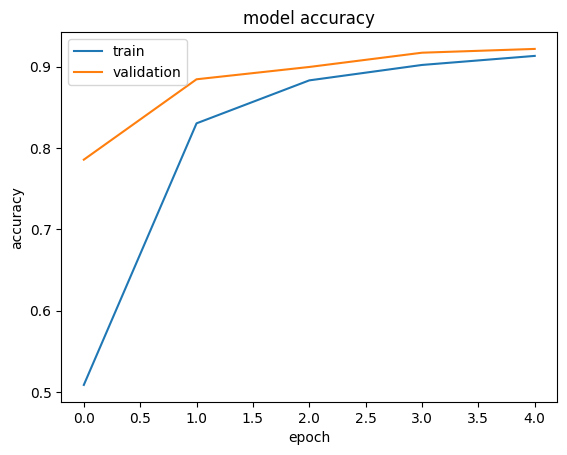

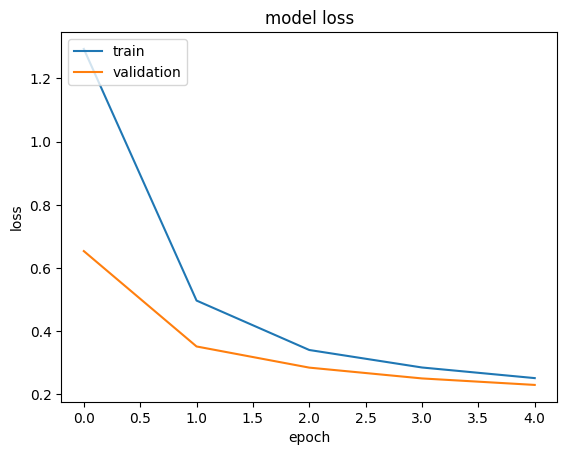

In [ ]:
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 4. Evaluation

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

236/236 [==============================] - 56s 233ms/step


In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(df_test.emotions, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df_test.emotions, predictions, average='micro') * 100))

Accuracy: 92.20%

F1 Score: 92.20


#### Plotting confusion Matrix:

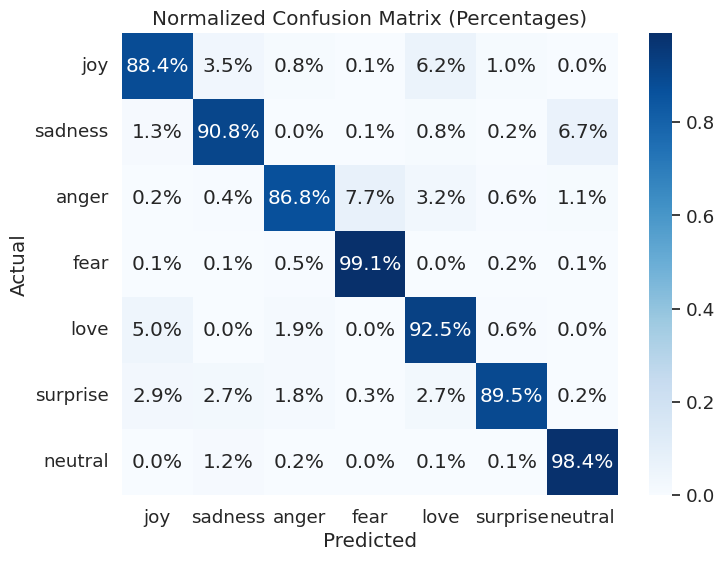

In [ ]:
import seaborn as sns

# Compute the confusion matrix
confusion = confusion_matrix(df_test.emotions, predictions)

# Normalize the confusion matrix as percentages
confusion_percent = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]

# Create a heatmap to visualize the confusion matrix as percentages
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion_percent, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names, fmt=".1%")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix (Percentages)')
plt.show()

#### Lets try other inputs:

In [ ]:
print('Message: {}\nPredicted: {}'.format(X_test[4], predictions[4]))

Message: look lyft ride fifty dollars free w lyft code cleo mk mirthful lovetosavemoney
Predicted: joy


In [ ]:
import time

message = ['delivery was hour late and my pizza was cold!']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 [==============================] - 0s 86ms/step
Message: ['delivery was hour late and my pizza was cold!']
predicted: anger (0.12 seconds)


# Save model

In [ ]:
# creates a HDF5 file 'my_model.h5'
model.save('models/biLSTM_w2v.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
predictor = load_model('models/biLSTM_w2v.h5')